In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

In [2]:
train_dir = "../train" #passing the path with training images
test_dir = "../test"   #passing the path with testing images

In [3]:
img_size = 48

In [4]:
train_datagen = ImageDataGenerator(#rotation_range = 180,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         #zoom_range = 0.2,
                                         validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

In [5]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                                                         )

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [6]:
X_train, y_train = next(train_generator)
X_test, y_test = next(validation_generator)

In [7]:
len(train_generator)

359

In [8]:
X_train.shape

(64, 48, 48, 1)

In [9]:
y_train.shape

(64, 7)

In [10]:
X_test.shape

(64, 48, 48, 1)

In [11]:
y_test.shape

(64, 7)

In [12]:
class_names = train_generator.class_indices

class_names_swap = {v: k for k, v in class_names.items()}
print(class_names_swap)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


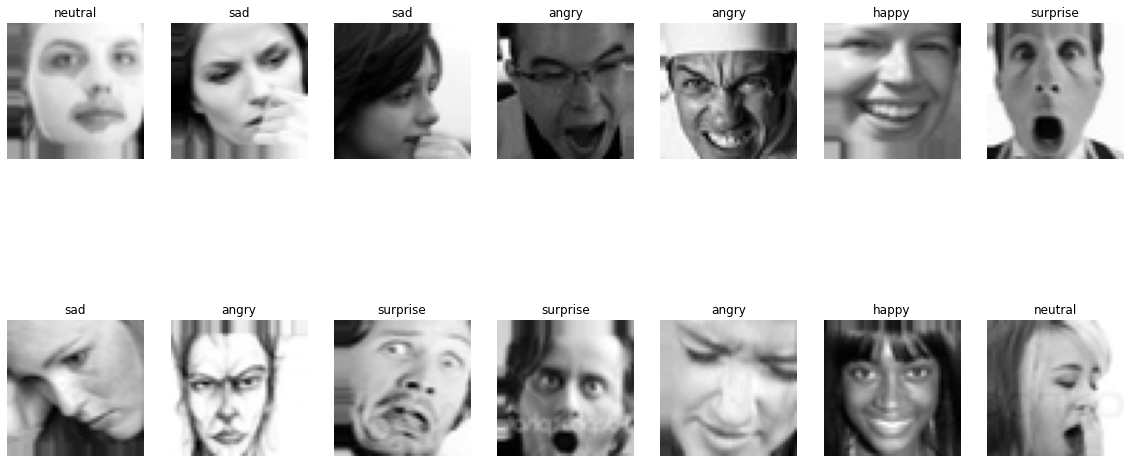

In [13]:
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np 

r = random.sample(range(X_train.shape[0]), 14)
for i in range(14):
    plt.subplot(2, 7, i+1)
    plt.imshow(X_train[r[i]],'gray')
    plt.title(class_names_swap[np.argmax(y_train[r[i]])])
    plt.axis("off")    

In [14]:
from sklearn.utils import class_weight 
import numpy as np

class_weights = class_weight.compute_class_weight(
            class_weight = 'balanced',
            classes = np.unique(train_generator.classes), 
            y = train_generator.classes)

train_class_weights = dict(enumerate(class_weights))
# model.fit_generator(..., class_weight=train_class_weights)

In [15]:
train_class_weights

{0: 1.0266404434114071,
 1: 9.401555464592715,
 2: 1.0009587727708533,
 3: 0.5684585684585685,
 4: 0.826068191627104,
 5: 0.8491570541259982,
 6: 1.2933160650937552}

In [16]:
class_names_swap

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [17]:
def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [18]:
def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [19]:
def model_four(shape = (32, 32, 3), classes = 10):
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = convolutional_block(x, 128)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 128)
    x = identity_block(x, 128)
    x = identity_block(x, 128)
    x = identity_block(x, 128)
    x = identity_block(x, 128)
    x = convolutional_block(x, 256)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = convolutional_block(x, 512)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 512)
    x = identity_block(x, 512)
    x = identity_block(x, 512)
    x = identity_block(x, 512)
    x = identity_block(x, 512)
    x = identity_block(x, 512)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 512)
    
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(256, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "model_two")
    return model

In [22]:
model = model_four(shape = (48, 48, 1), classes = 7)

epochs = 200
batch_size = 64
model.summary()

Model: "model_two"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 54, 54, 1)   0           ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv2d_62 (Conv2D)             (None, 27, 27, 64)   3200        ['zero_padding2d_1[0][0]']       
                                                                                                  
 batch_normalization_59 (BatchN  (None, 27, 27, 64)  256         ['conv2d_62[0][0]']      

                                                                  'conv2d_71[0][0]']              
                                                                                                  
 activation_67 (Activation)     (None, 7, 7, 128)    0           ['add_32[0][0]']                 
                                                                                                  
 dropout_5 (Dropout)            (None, 7, 7, 128)    0           ['activation_67[0][0]']          
                                                                                                  
 conv2d_72 (Conv2D)             (None, 7, 7, 128)    147584      ['dropout_5[0][0]']              
                                                                                                  
 batch_normalization_68 (BatchN  (None, 7, 7, 128)   512         ['conv2d_72[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_77 (BatchN  (None, 7, 7, 128)   512         ['conv2d_81[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_37 (Add)                   (None, 7, 7, 128)    0           ['batch_normalization_77[0][0]', 
                                                                  'activation_75[0][0]']          
                                                                                                  
 activation_77 (Activation)     (None, 7, 7, 128)    0           ['add_37[0][0]']                 
                                                                                                  
 conv2d_82 (Conv2D)             (None, 4, 4, 256)    295168      ['activation_77[0][0]']          
                                                                                                  
 batch_nor

 ormalization)                                                                                    
                                                                                                  
 activation_86 (Activation)     (None, 4, 4, 256)    0           ['batch_normalization_86[0][0]'] 
                                                                                                  
 conv2d_92 (Conv2D)             (None, 4, 4, 256)    590080      ['activation_86[0][0]']          
                                                                                                  
 batch_normalization_87 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_92[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_42 (Add)                   (None, 4, 4, 256)    0           ['batch_normalization_87[0][0]', 
          

                                                                                                  
 conv2d_101 (Conv2D)            (None, 4, 4, 256)    590080      ['activation_95[0][0]']          
                                                                                                  
 batch_normalization_96 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_101[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 activation_96 (Activation)     (None, 4, 4, 256)    0           ['batch_normalization_96[0][0]'] 
                                                                                                  
 conv2d_102 (Conv2D)            (None, 4, 4, 256)    590080      ['activation_96[0][0]']          
                                                                                                  
 batch_nor

 Normalization)                                                                                   
                                                                                                  
 add_51 (Add)                   (None, 2, 2, 512)    0           ['batch_normalization_105[0][0]',
                                                                  'dropout_8[0][0]']              
                                                                                                  
 activation_105 (Activation)    (None, 2, 2, 512)    0           ['add_51[0][0]']                 
                                                                                                  
 conv2d_112 (Conv2D)            (None, 2, 2, 512)    2359808     ['activation_105[0][0]']         
                                                                                                  
 batch_normalization_106 (Batch  (None, 2, 2, 512)   2048        ['conv2d_112[0][0]']             
 Normaliza

                                                                                                  
 batch_normalization_115 (Batch  (None, 2, 2, 512)   2048        ['conv2d_121[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 add_56 (Add)                   (None, 2, 2, 512)    0           ['batch_normalization_115[0][0]',
                                                                  'activation_113[0][0]']         
                                                                                                  
 activation_115 (Activation)    (None, 2, 2, 512)    0           ['add_56[0][0]']                 
                                                                                                  
 dropout_9 (Dropout)            (None, 2, 2, 512)    0           ['activation_115[0][0]']         
          

In [23]:
model.compile(
    optimizer = 'adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

In [24]:
import scipy.integrate

import scipy.special
import scipy

history = model.fit(x = train_generator,epochs = epochs,batch_size=batch_size,validation_data = validation_generator, class_weight=train_class_weights)

Epoch 1/200
359/359 [==============================] - 353s 934ms/step - loss: 2.1424 - accuracy: 0.1475 - val_loss: 1.9515 - val_accuracy: 0.1306
Epoch 2/200
359/359 [==============================] - 111s 309ms/step - loss: 1.9388 - accuracy: 0.1705 - val_loss: 1.9218 - val_accuracy: 0.1704
Epoch 3/200
359/359 [==============================] - 113s 316ms/step - loss: 1.9132 - accuracy: 0.1809 - val_loss: 1.8592 - val_accuracy: 0.2165
Epoch 4/200
359/359 [==============================] - 3892s 11s/step - loss: 1.8666 - accuracy: 0.2162 - val_loss: 1.9962 - val_accuracy: 0.0482
Epoch 5/200
359/359 [==============================] - 113s 314ms/step - loss: 1.8311 - accuracy: 0.2370 - val_loss: 1.9320 - val_accuracy: 0.2514
Epoch 6/200
359/359 [==============================] - 122s 341ms/step - loss: 1.8060 - accuracy: 0.2566 - val_loss: 1.7792 - val_accuracy: 0.3122
Epoch 7/200
359/359 [==============================] - 125s 348ms/step - loss: 1.7691 - accuracy: 0.2744 - val_loss: 1.

359/359 [==============================] - 128s 357ms/step - loss: 1.0206 - accuracy: 0.5827 - val_loss: 1.1777 - val_accuracy: 0.5635
Epoch 57/200
359/359 [==============================] - 128s 357ms/step - loss: 1.0097 - accuracy: 0.5864 - val_loss: 1.1529 - val_accuracy: 0.5642
Epoch 58/200
359/359 [==============================] - 127s 355ms/step - loss: 1.0149 - accuracy: 0.5800 - val_loss: 1.1976 - val_accuracy: 0.5510
Epoch 59/200
359/359 [==============================] - 125s 348ms/step - loss: 1.0111 - accuracy: 0.5827 - val_loss: 1.3016 - val_accuracy: 0.5042
Epoch 60/200
359/359 [==============================] - 117s 324ms/step - loss: 0.9964 - accuracy: 0.5893 - val_loss: 1.1668 - val_accuracy: 0.5559
Epoch 61/200
359/359 [==============================] - 117s 325ms/step - loss: 0.9857 - accuracy: 0.5945 - val_loss: 1.2406 - val_accuracy: 0.5307
Epoch 62/200
359/359 [==============================] - 116s 324ms/step - loss: 0.9888 - accuracy: 0.5946 - val_loss: 1.1310 

359/359 [==============================] - 117s 327ms/step - loss: 0.7544 - accuracy: 0.6872 - val_loss: 1.0973 - val_accuracy: 0.6034
Epoch 112/200
359/359 [==============================] - 118s 329ms/step - loss: 0.7500 - accuracy: 0.6871 - val_loss: 1.0925 - val_accuracy: 0.5985
Epoch 113/200
359/359 [==============================] - 118s 329ms/step - loss: 0.7311 - accuracy: 0.6957 - val_loss: 1.0953 - val_accuracy: 0.5992
Epoch 114/200
359/359 [==============================] - 118s 329ms/step - loss: 0.7129 - accuracy: 0.7039 - val_loss: 1.0344 - val_accuracy: 0.6180
Epoch 115/200
359/359 [==============================] - 118s 328ms/step - loss: 0.7063 - accuracy: 0.7044 - val_loss: 1.0198 - val_accuracy: 0.6271
Epoch 116/200
359/359 [==============================] - 118s 330ms/step - loss: 0.7499 - accuracy: 0.6891 - val_loss: 1.1014 - val_accuracy: 0.5978
Epoch 117/200
359/359 [==============================] - 118s 328ms/step - loss: 0.7972 - accuracy: 0.6718 - val_loss: 1

359/359 [==============================] - 118s 329ms/step - loss: 0.5635 - accuracy: 0.7685 - val_loss: 1.7600 - val_accuracy: 0.3876
Epoch 167/200
359/359 [==============================] - 117s 327ms/step - loss: 0.5997 - accuracy: 0.7507 - val_loss: 1.0537 - val_accuracy: 0.6194
Epoch 168/200
359/359 [==============================] - 118s 327ms/step - loss: 0.6229 - accuracy: 0.7490 - val_loss: 1.0617 - val_accuracy: 0.6257
Epoch 169/200
359/359 [==============================] - 117s 326ms/step - loss: 0.5736 - accuracy: 0.7643 - val_loss: 1.0565 - val_accuracy: 0.6327
Epoch 170/200
359/359 [==============================] - 117s 326ms/step - loss: 0.5310 - accuracy: 0.7784 - val_loss: 1.0427 - val_accuracy: 0.6459
Epoch 171/200
359/359 [==============================] - 117s 326ms/step - loss: 0.5155 - accuracy: 0.7899 - val_loss: 1.0373 - val_accuracy: 0.6411
Epoch 172/200
359/359 [==============================] - 117s 326ms/step - loss: 0.5031 - accuracy: 0.7887 - val_loss: 1

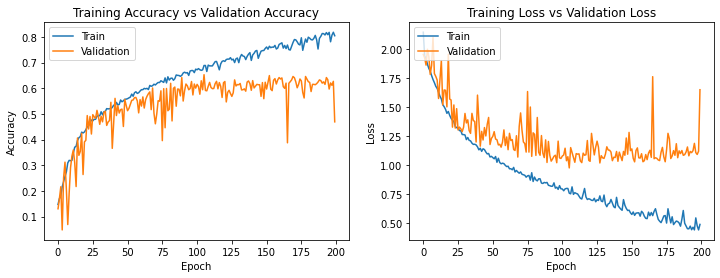

In [25]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [26]:
model.save('deeperdropout42_100_model.h5')
model.save_weights('deeperdropout42_100_weights.h5')

In [27]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

23/23 [==============================] - 2s 82ms/step - loss: 1.6475 - accuracy: 0.4693
final train accuracy = 57.40 , validation accuracy = 46.93


23/23 [==============================] - 4s 88ms/step
Confusion Matrix
[[39  9 34 33 21 43 12]
 [ 5  2  4  2  1  7  1]
 [41  6 41 27 21 55 13]
 [86 19 56 45 32 95 21]
 [54  6 43 29 26 71 17]
 [51  7 47 40 23 70 11]
 [29  7 21 33 14 51 11]]
Classification Report
              precision    recall  f1-score   support

       angry       0.13      0.20      0.16       191
     disgust       0.04      0.09      0.05        22
        fear       0.17      0.20      0.18       204
       happy       0.22      0.13      0.16       354
     neutral       0.19      0.11      0.14       246
         sad       0.18      0.28      0.22       249
    surprise       0.13      0.07      0.09       166

    accuracy                           0.16      1432
   macro avg       0.15      0.15      0.14      1432
weighted avg       0.17      0.16      0.16      1432



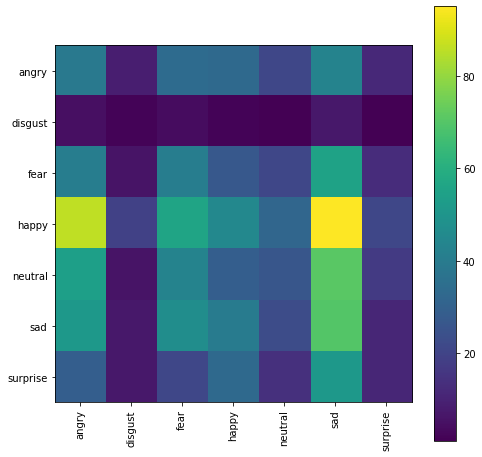

In [28]:
y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = validation_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(validation_generator.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

359/359 [==============================] - 29s 81ms/step
Confusion Matrix
[[ 660  109  452  473  406  901  195]
 [  62   12   45   74   34  101   21]
 [ 677  135  464  514  339  928  221]
 [1251  211  810  850  652 1627  371]
 [ 826  163  544  608  460 1093  278]
 [ 842  123  530  593  471 1072  233]
 [ 555   83  338  402  288  709  162]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.21      0.16      3196
     disgust       0.01      0.03      0.02       349
        fear       0.15      0.14      0.14      3278
       happy       0.24      0.15      0.18      5772
     neutral       0.17      0.12      0.14      3972
         sad       0.17      0.28      0.21      3864
    surprise       0.11      0.06      0.08      2537

    accuracy                           0.16     22968
   macro avg       0.14      0.14      0.13     22968
weighted avg       0.17      0.16      0.16     22968



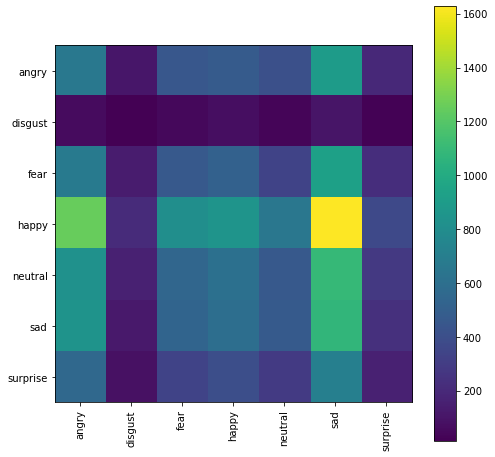

In [29]:
y_pred = model.predict(train_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = train_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(train_generator.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(train_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)